In [1]:
# Подключение пакетов
import os, sys, time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms

print('Numpy version:', np.version.version)

# Устанавливаем рабочую директорию в корень проекта
while not os.getcwd().endswith("gan-not"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
def show_image(data: torch.Tensor, title: str = "data example", eps=1e-5):
    """
    Преобразование image входных данных в RGB картинку и ее отображение.

    Args:
        data (torch.Tensor): вход модели в виде torch.tensor [1 x C x H x W] или [C x H x W]
        title (str): подпись к графику
    """
    if data.min() < -1 - eps or data.max() > 1 + eps:
        data = (data - data.min()) / (data.max() - data.min())
    else:
        data = (data / 2 + 0.5).clip(0, 1)
    if len(data.shape) == 4:
        data = data.squeeze(0)
    numpy_data = np.moveaxis(data.cpu().numpy(), 0, 2)
    plt.imshow(numpy_data, interpolation="lanczos")
    plt.grid()
    plt.axis("off")
    plt.title(title)
    
    plt.show()

def show_data_sample(sample):
    inp, tgt = sample
    show_image(torch.cat([inp.repeat(3 // inp.shape[0], 1, 1), tgt], dim=-1))

In [16]:
edge_detector = EdgeDetector()
edge_detector.gaussian.kernel

tensor([[[[0.0571, 0.1248, 0.0571],
          [0.1248, 0.2725, 0.1248],
          [0.0571, 0.1248, 0.0571]]],


        [[[0.0571, 0.1248, 0.0571],
          [0.1248, 0.2725, 0.1248],
          [0.0571, 0.1248, 0.0571]]],


        [[[0.0571, 0.1248, 0.0571],
          [0.1248, 0.2725, 0.1248],
          [0.0571, 0.1248, 0.0571]]]])

In [4]:
model = model_config.generator
model

UNet(
  (down_blocks): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ConvBlock(
      (features): Sequential(
        (0): LeakyReLU(negative_slope=0.2, inplace=True)
        (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
model = model_config.discriminator
model

PatchDiscriminator(
  (features): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [12]:
def move_images(destination, images):
    os.makedirs(destination, exist_ok=True)
    for image in images:
        os.rename(image, destination + "/" + os.path.basename(image))


def split_train_valid(dataset, train_size, seed = 42):
    set_random_seed(seed)
    np.random.shuffle(dataset.ids)
    train, valid = dataset.ids[:train_size], dataset.ids[train_size:]
    move_images(dataset.images_dir + "/train", train)
    move_images(dataset.images_dir + "/valid", valid)

In [13]:
from src.dataset import EdgesDataset
from src.utils import set_random_seed

dataset = EdgesDataset("C:/data/monogatari")
split_train_valid(dataset, train_size=1800)
dataset = EdgesDataset("C:/data/monogatari_white")
split_train_valid(dataset, train_size=1000)

In [17]:
from src.config import monogatari

data_config = monogatari.DataConfig()
model_config = monogatari.ModelConfig()
train_config = monogatari.TrainConfig()

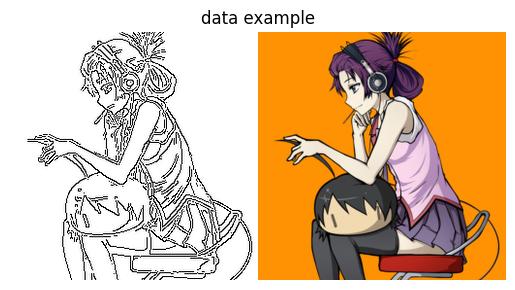

In [18]:
dataset = data_config.train_dataset
show_data_sample(dataset[0])

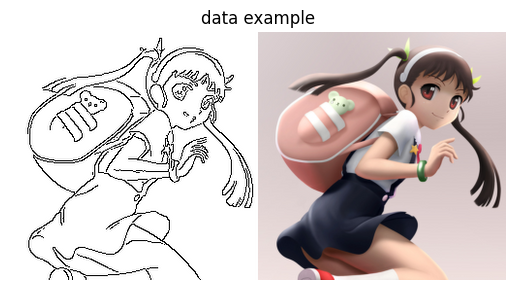

In [19]:
dataset = data_config.valid_dataset
show_data_sample(dataset[0])

In [5]:
from src.config import monogatari_white

data_config = monogatari_white.DataConfig()
model_config = monogatari_white.ModelConfig()
train_config = monogatari_white.TrainConfig()

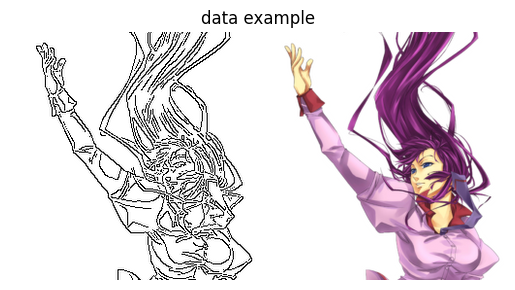

In [7]:
dataset = data_config.train_dataset
show_data_sample(dataset[0])

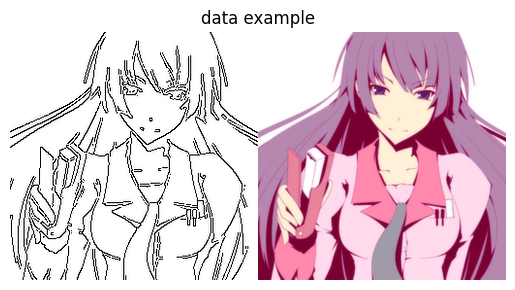

In [8]:
dataset = data_config.valid_dataset
show_data_sample(dataset[0])

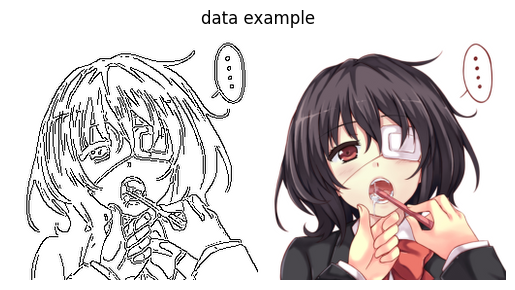

In [9]:
show_data_sample(dataset[1])

In [6]:
loader = DataLoader(
    data_config.valid_dataset,
    batch_size=4,
    shuffle=False
)
device = train_config.device
model = model_config.generator.to(device)
model.load_state_dict(torch.load(f"resources/models/monogatari_white_disloss0.02_genlr0.0002_dislr2e-05_batch8_epoch88.pth"))
with torch.no_grad():
    for input, target in loader:
        input = input.to(device)
        target = target.to(device)
        output = model(input)
        print(output.shape)
        break

torch.Size([4, 3, 256, 256])


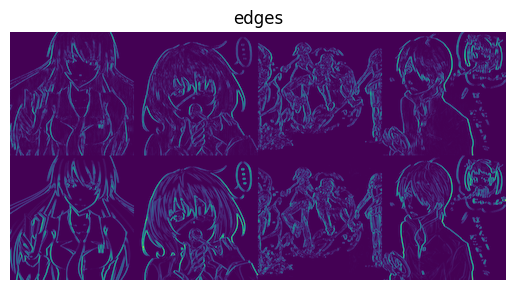

In [7]:
from src.models import EdgeDetector

edge_detector = EdgeDetector(denoise=False).to(device)
o_edges, t_edges = edge_detector(output), edge_detector(target)
o_edges = torch.cat(torch.unbind(o_edges, dim=0), dim=-1)
t_edges = torch.cat(torch.unbind(t_edges, dim=0), dim=-1)
show_image(torch.cat([o_edges, t_edges], dim=-2), title="edges")

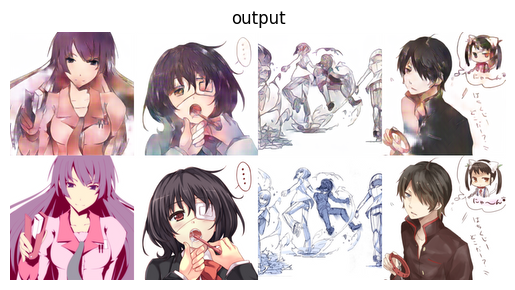

In [8]:
outputs = torch.cat(torch.unbind(output, dim=0), dim=-1)
targets = torch.cat(torch.unbind(target, dim=0), dim=-1)
show_image(torch.cat([outputs, targets], dim=-2), title="output")